In [1]:
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"]="1"

In [2]:
import torch
import numpy as np

from tqdm.autonotebook import tqdm
from matplotlib import pyplot as plt
from neuralop.models import FNO
from sklearn.gaussian_process.kernels import RBF

/var/folders/0g/6p58411j1tv6772_j1kq_lkh0000gn/T/ipykernel_25562/788083054.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [81]:
def rbf_kernel(T, lengthscale=1.0, variance=1.0, device='cpu'):
    t = np.arange(T, dtype=np.float32)
    return torch.tensor(RBF(lengthscale)(np.expand_dims(t,1)), device=device, dtype=torch.float32)

def kl_divergence_gp(mean, logvar, t=None, eps=1e-6):
    """
    mean: (B, D, T)
    logvar: (B, D, T)
    gp_cov: (T, T)  -- shared GP prior covariance matrix
    """
    B, D, T = mean.shape
    device = mean.device
    
    if t is not None:
        gp_cov = rbf_kernel(t)
    else:
        gp_cov = rbf_kernel(T)
    # Ensure positive definiteness for Cholesky
    gp_cov_stable = gp_cov + eps * torch.eye(T, device=device)
    L = torch.linalg.cholesky(gp_cov_stable)  # (T, T)

    # Inverse and log determinant via Cholesky
    inv_gp_cov = torch.cholesky_inverse(L)  # (T, T)
    log_det_gp = torch.logdet(gp_cov + eps * torch.eye(T))

    # Posterior diagonal covariance and its log det
    var = logvar.exp()  # (B, D, T)
    log_det_post = torch.sum(logvar, dim=-1)  # (B, D)

    # Trace term: Tr(Sigma_p^{-1} Sigma_q)
    trace_term = torch.einsum('ij,bdj->bd', inv_gp_cov, var)  # (B, D)

    # Mahalanobis term: (mu - 0)^T Σ_p^{-1} (mu - 0)
    maha_term = torch.einsum('bdt,ij,bdj->bd', mean, inv_gp_cov, mean)  # (B, D)

    # Final KL divergence (per dimension per batch)
    kl = 0.5 * (log_det_gp - log_det_post - T + trace_term + maha_term)  # (B, D)

    print("log_det_gp:", log_det_gp.item())
    print("log_det_post (mean):", log_det_post.mean().item())
    print("trace_term (mean):", trace_term.mean().item())
    print("maha_term (mean):", maha_term.mean().item())
    print("KL (mean):", kl.mean().item())

    # Sum over dimensions
    return kl.sum(dim=-1).mean()  # mean over batch

In [82]:
class Encoder(torch.nn.Module):
    def __init__(self, modes, input_dim, hidden_dim, model_dim, bidirectional=False, with_t=False):
        
        super().__init__()
        self.with_t = with_t
        self.bidirectional = bidirectional
        if self.with_t:
            input_dim += 1

        
        self.forward_encoder = FNO(n_modes=modes, in_channels=input_dim, out_channels=2*hidden_dim, hidden_channels=model_dim)
        if self.bidirectional:
            self.backward_encoder = FNO(n_modes=modes, in_channels=input_dim, out_channels=2*hidden_dim, hidden_channels=model_dim)
    def forward(self, x, t=None):
        if t:
            x = torch.concatenate([x, t], dim=1)
        
        mu, log_var = torch.chunk(self.forward_encoder(x), chunks=2, dim=1)

        if self.bidirectional:
            mu_backward, log_var_backward = torch.chunk(self.backward_encoder(torch.flip(x, dims=(1,))), chunks=2, dim=1)
            mu = torch.concat([mu, mu_backward], dim=1)
            log_var = torch.concat([log_var, log_var_backward], dim=1)
    
        return mu, log_var
    
    def sample_posterior(self, mu, log_var):
        
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)

        return mu + eps * std
    
    def log_prob(self, z, mu, log_var):
        var = torch.exp(log_var)

        log_prob = -0.5 * (torch.log(2*torch.pi* var) + ((z-mu)**2)/var)

        return log_prob.sum(dim=1)


In [83]:
class Decoder(torch.nn.Module):
    def __init__(self, modes, input_dim, hidden_dim, model_dim, with_t=False):
        
        super().__init__()
        self.with_t = with_t

        if self.with_t:
            input_dim += 1

        self.decoder = FNO(n_modes=modes, in_channels=input_dim, out_channels=hidden_dim, hidden_channels=model_dim)

    def forward(self, z, t=None):

        if self.with_t and not t:
            raise ValueError("t is missing as an input but `with_t` is True which will cause shape errors!")
        elif self.with_t and t:
            z = torch.concatenate([z, t], dim=1)
        else:
            pass
        
        x_hat = self.decoder(z)

        return x_hat
    
    

In [84]:
class NOVAE(torch.nn.Module):
    def __init__(self, input_dim, latent_dim, encoder_modes, encoder_size, decoder_modes, decoder_size, bidirectional=False, prior_mean=0.0, prior_std = 1.0, beta=1.0, with_t = False,
                 use_dynamics=False, dynamics_modes=(16,), dynamics_size=16, dynamics_steps=1):
        super().__init__()

        self.beta = beta
        self.prior_mean = torch.tensor(prior_mean)
        self.prior_std = torch.tensor(prior_std)
        self.use_dynamics = use_dynamics
        self.dynamics_steps = dynamics_steps
        self.bidirectional = bidirectional

        # Encoder FNO: maps (x(t)) -> hidden features
        self.encoder = Encoder(encoder_modes, input_dim, latent_dim, encoder_size, bidirectional, with_t)

        self.decoder = Decoder(decoder_modes, 
                               2 * latent_dim if bidirectional else latent_dim,
                               input_dim, 
                               decoder_size, with_t)

        # Optional dynamics model in latent space
        if self.use_dynamics:
            self.dynamics_model = FNO(n_modes=dynamics_modes, in_channels=latent_dim, out_channels=latent_dim, hidden_channels=dynamics_size)

    def forward(self, x, t_coords=None):
        # x: (batch, time, input_dim)
        # t_coords: (batch, time, 1)

        mu, logvar = self.encoder(x, t_coords)

        z = self.encoder.sample_posterior(mu, logvar)

        if self.use_dynamics:
            z_dyn = z
            for _ in range(self.dynamics_steps):
                z_dyn = self.dynamics_model(z_dyn)
            z = z_dyn

        x_hat = self.decoder(z, t_coords)

        return x_hat, mu, logvar, z

    def compute_loss(self, x_hat, x, mu, logvar):
        recon_loss = torch.nn.functional.mse_loss(x_hat, x, reduction='mean')

        kl_loss = kl_divergence_gp(mu, logvar)
        
        elbo = recon_loss + self.beta * kl_loss
        return {"elbo": elbo, "reconstruction": recon_loss, "kl": kl_loss}

In [85]:
x = torch.randn(10,128,32)
model = NOVAE(128, 16, (16,), 64, (16,), 64)
x_hat, mu, logvar, z = model(x)
x_hat.shape, mu.shape, logvar.shape, z.shape

(torch.Size([10, 128, 32]),
 torch.Size([10, 16, 32]),
 torch.Size([10, 16, 32]),
 torch.Size([10, 16, 32]))

In [86]:
model.compute_loss(x_hat, x, mu, logvar)

log_det_gp: -20.862089157104492
log_det_post (mean): -0.7667017579078674
trace_term (mean): 13.01875114440918
maha_term (mean): 2.415985107421875
KL (mean): -18.330326080322266


{'elbo': tensor(-292.2878, grad_fn=<AddBackward0>),
 'reconstruction': tensor(0.9975, grad_fn=<MseLossBackward0>),
 'kl': tensor(-293.2852, grad_fn=<MeanBackward0>)}

In [68]:
# True decoder: a small MLP
class MLP(torch.nn.Module):
    def __init__(self, input_dim, projection_dim):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, projection_dim)
        )

    def forward(self, x):
        return self.net(x)

In [11]:
class DummyDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_size=100, seq_len=100, latent_dim=3, input_dim=1, device="cpu"):
        """
        Create a synthetic dataset where x(t) = decoder(z(t), t), with known latent trajectories
        """

        self.dataset_size = dataset_size
        self.seq_len = seq_len
        self.latent_dim = latent_dim

        self.input_dim = input_dim
        self.t = torch.linspace(0, 1, seq_len).unsqueeze(0).repeat(dataset_size, 1)  # (B, T)
        self.t_coords = self.t.unsqueeze(-1)  # (B, T, 1)

        if device == "cuda" and torch.cuda.is_available():
            self.device = torch.device(device)
        elif device == "mps" and torch.mps.is_available():
            self.device = torch.device(device)
        else:
            self.device = torch.device("cpu")
        self.projection = MLP(input_dim=self.latent_dim, projection_dim=self.input_dim)

        self.z_true = torch.stack([torch.sin(2 * torch.pi * self.t + 2*torch.pi/(i+1)) if i %2 == 0 else torch.cos(2 * torch.pi * self.t + 2*torch.pi/(i+1)) for i in range(self.latent_dim)], dim=-1)  # (B, T, latent_dim)

        #projection = MLP(input_dim=self.latent_dim, projection_dim=self.input_dim)

        with torch.no_grad():
            self.x = self.projection(self.z_true)  # (B, T, input_dim)
        # True latents: simple sinusoids

    def __len__(self):
        return self.dataset_size
    
    def __getitem__(self, idx):
        
        x = self.x[idx,:,:].squeeze().T
        z_true = self.z_true[idx,:,:].squeeze().T


        return x.to(self.device), z_true.to(self.device)

In [12]:

def frange_cycle_linear(start, stop, n_epoch, n_cycle=4, ratio=0.5):
    L = np.ones(n_epoch)
    period = n_epoch/n_cycle
    step = (stop-start)/(period*ratio) # linear schedule

    for c in range(n_cycle):

        v , i = start , 0
        while v <= stop and (int(i+c*period) < n_epoch):
            L[int(i+c*period)] = v
            v += step
            i += 1
    return L    


def frange_cycle_sigmoid(start, stop, n_epoch, n_cycle=4, ratio=0.5):
    L = np.ones(n_epoch)
    period = n_epoch/n_cycle
    step = (stop-start)/(period*ratio) # step is in [0,1]
    
    # transform into [-6, 6] for plots: v*12.-6.

    for c in range(n_cycle):

        v , i = start , 0
        while v <= stop:
            L[int(i+c*period)] = 1.0/(1.0+ np.exp(- (v*12.-6.)))
            v += step
            i += 1
    return L    


#  function  = 1 − cos(a), where a scans from 0 to pi/2

def frange_cycle_cosine(start, stop, n_epoch, n_cycle=4, ratio=0.5):
    L = np.ones(n_epoch)
    period = n_epoch/n_cycle
    step = (stop-start)/(period*ratio) # step is in [0,1]
    
    # transform into [0, pi] for plots: 

    for c in range(n_cycle):

        v , i = start , 0
        while v <= stop:
            L[int(i+c*period)] = 0.5-.5*np.cos(v*np.pi)
            v += step
            i += 1
    return L    

def frange(start, stop, step, n_epoch):
    L = np.ones(n_epoch)
    v , i = start , 0
    while v <= stop:
        L[i] = v
        v += step
        i += 1
    return L

In [13]:
frange_cycle_cosine(0, 0.1, n_epoch=10, n_cycle=2, ratio=0.75)


array([0.        , 0.00175357, 0.00700198, 0.01570842, 1.        ,
       0.        , 0.00175357, 0.00700198, 0.01570842, 1.        ])

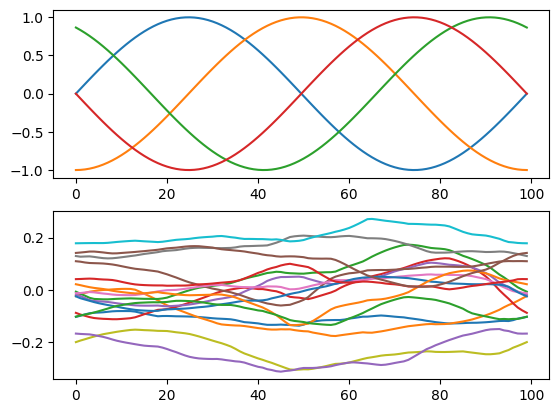

In [14]:
ds = DummyDataset(latent_dim=4, input_dim=16)
x, z_true = ds[0]

fig,axs=plt.subplots(2)
axs[0].plot(z_true.T)
axs[1].plot(x.T)

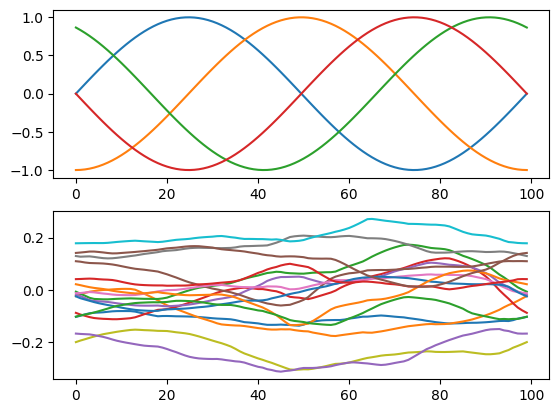

In [15]:
x, z_true = ds[1]

fig,axs=plt.subplots(2)
axs[0].plot(z_true.T)
axs[1].plot(x.T)

In [16]:
z_true.var()

tensor(0.5006)

In [32]:
n_epochs = 500
batch_size = 128
dataset_size = batch_size * 100
latent_dim = 16
projection_dim = 128
betas = np.ones(n_epochs)
#prior_std = np.sqrt(1)


model = NOVAE(projection_dim, latent_dim, (16,), 64, (16,), 64, beta=betas[0])
model.to("mps")

ds = DummyDataset(dataset_size=dataset_size, latent_dim=latent_dim, input_dim=projection_dim, device="mps")
dl = torch.utils.data.DataLoader(ds, batch_size=batch_size)

optimizer = torch.optim.Adam(model.parameters())
per_epoch_loss = {"elbo":[], "kl": [], "reconstruction": []}
per_batch_loss = {"elbo":[], "kl": [], "reconstruction": []}

epoch_progress_bar = tqdm(range(n_epochs), desc="epochs")
for i in epoch_progress_bar:

    batch_progress_bar = enumerate(dl) #tqdm(enumerate(dl), desc="batches", total=len(dl), nrows=1, position=1, leave=True)
    for j, batch in batch_progress_bar:
        x, z_true = batch

        optimizer.zero_grad()

        x_hat, mu, logvar, z_hat = model(x)
        loss = model.compute_loss(x_hat=x_hat, x=x, mu=mu, logvar=logvar)

        loss["elbo"].backward()
        optimizer.step()

        per_batch_loss["elbo"].append(loss["elbo"].item())
        per_batch_loss["kl"].append(loss["kl"].item())
        per_batch_loss["reconstruction"].append(loss["reconstruction"].item())

        #batch_progress_bar.set_postfix({key: val.item() for key, val in loss.items()})

    per_epoch_loss["elbo"].append(np.mean(per_batch_loss["elbo"]))
    per_epoch_loss["kl"].append(np.mean(per_batch_loss["kl"]))
    per_epoch_loss["reconstruction"].append(np.mean(per_batch_loss["reconstruction"]))

    desc = {key: np.mean(val) for key, val in per_batch_loss.items()}
    desc["beta"] = model.beta
    epoch_progress_bar.set_postfix(desc)

    per_batch_loss["elbo"] = []
    per_batch_loss["kl"] = []
    per_batch_loss["reconstruction"] = []

    
    
    model.beta = betas[i]

    


epochs:   0%|          | 0/500 [00:00<?, ?it/s]

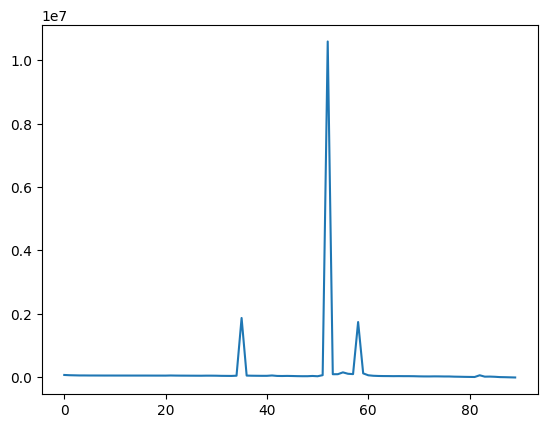

In [29]:
plt.plot(per_epoch_loss["kl"][10:100])

In [33]:
model.eval()
with torch.no_grad():
    x, z_true = ds[0]
    mu, logvar = model.encoder(x.unsqueeze(0))
    print(mu.mean(), logvar.mean().exp())
    z_samples = []
    for i in range(1000):
        z_samples.append(model.encoder.sample_posterior(mu, logvar))
    z_samples = torch.concat(z_samples, dim=0)
    x_samples = model.decoder(z_samples)
    z = z_samples.mean(dim=0)
    x_hat = x_samples.mean(dim=0)
z.shape, x_hat.shape

tensor(13.6270, device='mps:0') tensor(6.9659e-13, device='mps:0')


(torch.Size([16, 100]), torch.Size([128, 100]))

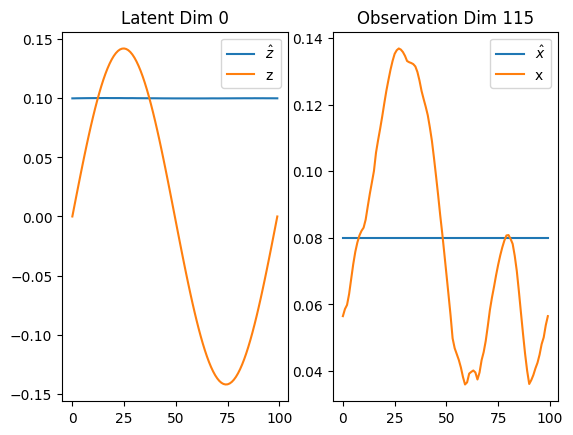

In [34]:
fig, axs = plt.subplots(1,2)
latent_ind = np.random.choice(np.arange(z.shape[0]))
obs_ind = np.random.choice(np.arange(x_hat.shape[0]))


z_hat_norm = (z.cpu().numpy().squeeze().T)[:,latent_ind]
z_hat_norm = z_hat_norm / np.linalg.norm(z_hat_norm)
z_norm = (z_true.cpu().numpy().T)[:,latent_ind]
z_norm = z_norm / np.linalg.norm(z_norm)

axs[0].set_title(f"Latent Dim {latent_ind}")
axs[0].plot(z_hat_norm, label=r"$\hat{z}$")
axs[0].plot(z_norm, label="z")
axs[0].legend()

axs[1].set_title(f"Observation Dim {obs_ind}")
axs[1].plot(x_hat.cpu().detach().numpy().T[:,obs_ind], label=r"$\hat{x}$")
axs[1].plot(x.cpu().detach().numpy().T[:,obs_ind], label="x")
axs[1].legend()

In [20]:
z_true.shape

torch.Size([16, 100])

In [21]:
batch = next(iter(dl))
x, z_true = batch
with torch.no_grad():
    x_hat, _, _ = model(x)
x_hat.shape

ValueError: too many values to unpack (expected 3)

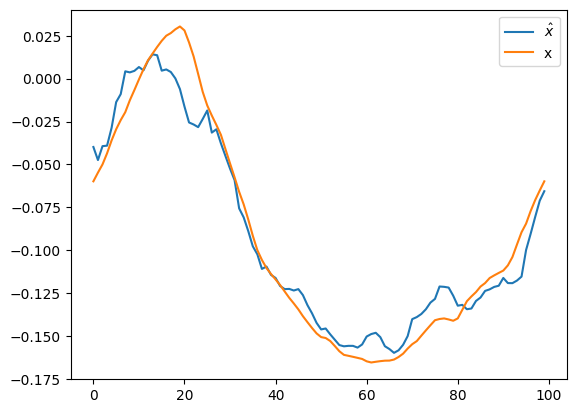

In [ ]:
plt.plot(x_hat.cpu().detach().numpy()[0,:,:].T[:,0], label=r"$\hat{x}$")
plt.plot(x.cpu().detach().numpy()[0,:,:].T[:,0], label="x")
plt.legend()

In [ ]:
x

tensor([[[-0.0598, -0.0548, -0.0500,  ..., -0.0708, -0.0652, -0.0598],
         [ 0.0532,  0.0506,  0.0471,  ...,  0.0558,  0.0549,  0.0532],
         [ 0.0409,  0.0409,  0.0404,  ...,  0.0393,  0.0404,  0.0409],
         ...,
         [-0.0488, -0.0546, -0.0607,  ..., -0.0385, -0.0435, -0.0488],
         [ 0.0232,  0.0275,  0.0320,  ...,  0.0149,  0.0190,  0.0232],
         [-0.1102, -0.1044, -0.0985,  ..., -0.1218, -0.1161, -0.1102]],

        [[-0.0598, -0.0548, -0.0500,  ..., -0.0708, -0.0652, -0.0598],
         [ 0.0532,  0.0506,  0.0471,  ...,  0.0558,  0.0549,  0.0532],
         [ 0.0409,  0.0409,  0.0404,  ...,  0.0393,  0.0404,  0.0409],
         ...,
         [-0.0488, -0.0546, -0.0607,  ..., -0.0385, -0.0435, -0.0488],
         [ 0.0232,  0.0275,  0.0320,  ...,  0.0149,  0.0190,  0.0232],
         [-0.1102, -0.1044, -0.0985,  ..., -0.1218, -0.1161, -0.1102]],

        [[-0.0598, -0.0548, -0.0500,  ..., -0.0708, -0.0652, -0.0598],
         [ 0.0532,  0.0506,  0.0471,  ...,  0